### **0. Notebook Overview and Learning Goals**

In the previous notebook, we explored the concept of **transfer learning** and understood how pretrained convolutional neural networks (CNNs) like ResNet-18 can act as feature extractors.  
We visualized what these models have already learned from ImageNet and built intuition for why it makes sense to reuse such representations rather than train everything from scratch.

In this notebook, we move one step further — from **understanding** to **training**.  
We will now **train only the classifier head** of our model while keeping the pretrained **convolutional backbone frozen**. This process is known as **feature extraction**.

The idea is simple yet powerful:
- The frozen backbone already encodes general visual features such as edges, shapes, and textures.
- Our new classifier head will learn how to **combine these features** to recognize our specific 10 Caltech-101 categories.
- By training only the final layer, we greatly reduce computation, minimize overfitting, and leverage the power of transfer learning even with limited data.

In this notebook, we will:

1. **Load** the pretrained model we prepared in NB01.  
2. **Train only the classifier head** using our Caltech-101 teaching subset.  
3. **Track** loss and accuracy over epochs to observe learning progress.  
4. **Evaluate** the model’s performance and reflect on why transfer learning works so efficiently.

> We remind ourselves that the goal here is not to achieve perfect accuracy, but to build intuition about how pretrained features help us learn quickly and effectively — even with small datasets.


**Import libraries & setup**

In [3]:
# --- Basic Imports and Setup ---
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os, json
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Device configuration (CPU-friendly)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


---

### **1. Recap: From Pretraining to Feature Extraction**

In the previous notebook, we explored how a deep convolutional neural network (CNN) such as ResNet-18 learns hierarchical features from data.  
The early layers detect simple patterns like **edges**, **corners**, and **color gradients**, while deeper layers capture more **abstract and semantic concepts** such as shapes, textures, or even object parts.

By the time the model reaches the final fully connected layer, it has transformed raw pixel information into **high-level feature representations** that summarize the essential characteristics of an image.  
This rich representation is what allows us to reuse pretrained models for new tasks — a process we call **transfer learning**.

In NB01, we froze all pretrained layers and replaced the classifier head with a new one designed for our own dataset (10 Caltech-101 classes).  
Now, we will train only that head while keeping the rest of the network frozen.

We call this process **feature extraction** because we are not changing the features themselves — the pretrained backbone acts as a **fixed feature extractor**.  
Only the final classifier learns how to map those existing features to our new label space.

Mathematically, let the pretrained network be represented as:

$$
f(x) = h_\theta(x)
$$

where $h_\theta$ denotes the feature extractor (all convolutional layers) with parameters $\theta$.  
We then add a new classifier $g_\phi$ with parameters $\phi$ (our trainable layer).  
Our task is to learn $\phi$ while keeping $\theta$ constant:

$$
y = g_\phi(h_\theta(x))
$$

By setting `requires_grad=False` for all parameters in $\theta$, we ensure that gradients are not computed or propagated backward through the frozen layers.  
This saves computation and prevents altering the already learned representations.


**Illustrating Gradient Freezing**

In [15]:
# Load pretrained model (ResNet18)
model = models.resnet18(weights='IMAGENET1K_V1')

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace final layer for 10-class Caltech subset
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

# Verify which layers are frozen vs. trainable
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Frozen parameters: {total_params - trainable_params:,}")


Total parameters: 11,181,642
Trainable parameters: 5,130
Frozen parameters: 11,176,512


As we can see, only the parameters of the final fully connected layer remain trainable.  

The rest of the network acts as a **static feature extractor**, producing meaningful embeddings for each image.  

This is the core idea behind **feature extraction** — we reuse knowledge learned from a large dataset (ImageNet) and adapt it to a new but smaller domain (Caltech-101) with minimal training effort.


---

**✅ Code Task 11.2.1.1: “Freeze vs Trainable” on another pretrained model (VGG16)**

**Student instruction:** Inspect transfer learning with VGG16: load pretrained weights, freeze the backbone, replace the classifier head for num_classes, and report parameter counts and trainable tensor names. Keep the head trainable only.

In [ ]:
from torchvision import models
import torch.nn as nn

# Use class_names/num_classes from NB02 setup
# 1) Load VGG16 with pretrained weights
CT_vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

# 2) Freeze all parameters
for p in ....parameters():
    p.requires_grad = ...

# 3) Replace classifier head to match our dataset
in_features = CT_vgg.classifier[-1].in_features
CT_vgg.classifier[-1] = nn.Linear(..., ...)

# 4) Ensure ONLY the classifier is trainable
for name, p in CT_vgg.named_parameters():
    if name.startswith("classifier."):
        p.requires_grad = True

CT_total_params = sum(p.numel() for p in CT_vgg.parameters())
CT_trainable_params = sum(p.numel() for p in CT_vgg.parameters() if p.requires_grad)
CT_trainable_names = [n for n, p in CT_vgg.named_parameters() if p.requires_grad]

print(f"[VGG16] total={...:,}  trainable={...:,}")
print("[VGG16] trainable tensors (head expected):")
for n in CT_trainable_names[:12]:
    print("  -", n)

**Instructor Solution**

In [ ]:
from torchvision import models
import torch.nn as nn

CT_vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
for p in CT_vgg.parameters():
    p.requires_grad = False

in_features = CT_vgg.classifier[-1].in_features
CT_vgg.classifier[-1] = nn.Linear(in_features, 10)

for name, p in CT_vgg.named_parameters():
    if name.startswith("classifier."):
        p.requires_grad = True

CT_total_params = sum(p.numel() for p in CT_vgg.parameters())
CT_trainable_params = sum(p.numel() for p in CT_vgg.parameters() if p.requires_grad)
CT_trainable_names = [n for n, p in CT_vgg.named_parameters() if p.requires_grad]

print(f"[VGG16] total={CT_total_params:,}  trainable={CT_trainable_params:,}")
print("[VGG16] trainable tensors (head expected):")
for n in CT_trainable_names[:12]:
    print("  -", n)


[VGG16] total=134,301,514  trainable=119,586,826
[VGG16] trainable tensors (head expected):
  - classifier.0.weight
  - classifier.0.bias
  - classifier.3.weight
  - classifier.3.bias
  - classifier.6.weight
  - classifier.6.bias


In [ ]:
assert 'CT_vgg' in globals(), "❌ CT_vgg not defined."
assert any(n.startswith("classifier.") for n in CT_trainable_names), "❌ No classifier params are trainable."
assert all((not p.requires_grad) or n.startswith("classifier.") 
           for n,p in CT_vgg.named_parameters()), "❌ Found trainable params outside classifier."
assert CT_trainable_params > 0 and CT_trainable_params < CT_total_params, "❌ Trainable count looks wrong."
print("✅ CT_Task 1 passed.")

---

### **2. Reloading Checkpoints and Setup**

We now restore the exact model state we prepared in NB01 so that we can **train only the classifier head** without rebuilding everything from scratch.  
We will:

- **Load the untrained checkpoint** we saved earlier (frozen pretrained backbone + new classifier head).  
- **Load the `class_to_idx` mapping** so that label indices remain consistent across notebooks.  
- **Recreate the dataloaders** (train, validation, test) with the same ImageNet-compatible preprocessing.  
- **Verify trainability** to ensure that only the classifier head’s parameters have `requires_grad=True`.  
- Print a short **summary** showing total vs. trainable parameters.

This careful initialization guarantees **reproducibility** and prevents subtle label-order mismatches between notebooks.


**Load checkpoint, mapping, and data loaders**

In [16]:
import os, json, torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from pathlib import Path

# --- Paths (must match NB01 saves) ---
DATA_ROOT = Path("./data/caltech101_10")
CKPT_DIR  = Path("./checkpoints")
CKPT_PATH = CKPT_DIR / "resnet18_frozen_init.pth"
MAP_PATH  = CKPT_DIR / "class_to_idx.pth"

assert DATA_ROOT.exists(), f"Dataset not found at {DATA_ROOT}"
assert CKPT_PATH.exists(), f"Checkpoint not found at {CKPT_PATH} (run NB01 saves first)"
assert MAP_PATH.exists(), f"class_to_idx mapping not found at {MAP_PATH}"

# --- Load class mapping and derive ordered class list ---
class_to_idx = torch.load(MAP_PATH, weights_only = False)
# Build list of class names ordered by their index (0..K-1)
idx_to_class = {v:k for k, v in class_to_idx.items()}
class_names = [idx_to_class[i] for i in range(len(idx_to_class))]
num_classes = len(class_names)
print(f"[info] Classes ({num_classes}): {class_names}")

# --- Preprocessing pipeline (must match NB01) ---
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]
transform = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
])

# --- Datasets and DataLoaders (same split folders) ---
train_ds = datasets.ImageFolder(DATA_ROOT / "train", transform=transform)
val_ds   = datasets.ImageFolder(DATA_ROOT / "val",   transform=transform)
test_ds  = datasets.ImageFolder(DATA_ROOT / "test",  transform=transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=32, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=32, shuffle=False, num_workers=0)

print(f"[info] Dataset sizes → train={len(train_ds)}, val={len(val_ds)}, test={len(test_ds)}")

# --- Recreate model (same architecture as NB01) ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Freeze backbone
for p in model.parameters():
    p.requires_grad = False

# Replace head sized to our classes (same as NB01) and load the saved state
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)

state_dict = torch.load(CKPT_PATH, map_location="cpu", weights_only = False)
model.load_state_dict(state_dict, strict=True)
model = model.to(device)
model.eval()

print("[info] Loaded frozen backbone + new head from checkpoint.")


[info] Classes (10): ['Faces', 'Motorbikes', 'airplanes', 'butterfly', 'camera', 'chair', 'laptop', 'lotus', 'panda', 'watch']
[info] Dataset sizes → train=964, val=209, test=204
[info] Loaded frozen backbone + new head from checkpoint.


**Verify trainability and print a compact summary**

In [17]:
# Count params
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

# List trainable tensors (should only be 'fc.*')
trainable_names = [n for n, p in model.named_parameters() if p.requires_grad]

print(f"[summary] Total parameters:     {total_params:,}")
print(f"[summary] Trainable parameters: {trainable_params:,}")
print("[summary] Trainable tensors:")
for n in trainable_names:
    print("  -", n)

# Safety check
assert all(n.startswith("fc.") for n in trainable_names), \
       "Unexpected trainable parameters outside the classifier head."

print("[check] Only the classifier head is trainable — setup is correct.")


[summary] Total parameters:     11,181,642
[summary] Trainable parameters: 5,130
[summary] Trainable tensors:
  - fc.weight
  - fc.bias
[check] Only the classifier head is trainable — setup is correct.


By restoring the exact model weights and label mapping from NB01, we ensure that:
 - Our **label indices** align with the correct class names.
 - Only the **new classifier head** will update during training.
 - The pretrained **feature extractor** remains fixed, preserving the knowledge learned from ImageNet.

With this foundation in place, we can now define the **loss**, **optimizer**, and a concise **training–validation loop** to perform feature extraction efficiently on CPU.


---

### **3. Loss Function, Optimizer, and Training Loop Design**

We now set up the **objective** and the **training loop** to learn only the **new classifier head** while keeping the pretrained backbone frozen.

**a) Criterion: Cross-Entropy Loss**
For a multi-class problem with one correct class per image, we use **cross-entropy loss**.  
If the model outputs logits $\mathbf{z} \in \mathbb{R}^K$ and the true class index is $y \in \{0,\dots,K-1\}$, the loss for one example is:
$$
\mathcal{L}(\mathbf{z}, y) = - \log \left( \frac{e^{z_y}}{\sum_{j=0}^{K-1} e^{z_j}} \right)
$$
Intuitively, this penalizes the model when the **softmax probability** assigned to the true class is low.

**b) Optimizer: Adam (only classifier parameters)**
We optimize **only** the classifier head parameters, e.g., `model.fc.parameters()`.  
The pretrained convolutional layers remain frozen (`requires_grad=False`) and therefore **do not receive gradients** or updates.

**c) Scheduler (Optional)**
A learning-rate scheduler (e.g., `StepLR`) gently reduces the learning rate as training progresses.  
This is optional for our short CPU-friendly runs, but helpful for demonstrating stable training practice.

**d) Training–Validation Loop**
We train for a **small number of epochs** (e.g., 5-10) to stay within a few minutes on CPU.  
Each epoch:
- **Train phase**: compute `train_loss` by averaging batch losses; update only the classifier head.
- **Validation phase**: compute `val_loss` and `val_acc` with `torch.no_grad()` (no gradient tracking); do **not** update weights.

We log `train_loss`, `val_loss`, and `val_acc` **per epoch** so we can visualize learning curves in the next section.  
Because we froze the backbone, we expect **rapid improvement** even with limited data.


**Define criterion, optimizer (head-only), and optional scheduler**

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim

# 1) Loss function: multi-class cross-entropy
criterion = nn.CrossEntropyLoss()

# 2) Optimizer: Adam on the classifier head only
#    (Backbone params are frozen, so they won't appear here.)
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3, weight_decay=1e-4)

# 3) Optional scheduler: gently decay LR every few epochs
use_scheduler = True
if use_scheduler:
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)
else:
    scheduler = None

print("[ok] Loss, optimizer (head-only), and scheduler are set.")


[ok] Loss, optimizer (head-only), and scheduler are set.


**Helper functions: train one epoch & evaluate**

In [19]:
import torch
import torch.nn.functional as F

def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()  # enables dropout/bn if present (not critical here but good practice)
    running_loss = 0.0
    total = 0

    for xb, yb in dataloader:
        xb, yb = xb.to(device), yb.to(device)

        # Forward
        logits = model(xb)
        loss = criterion(logits, yb)

        # Backward (only classifier head has requires_grad=True)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate
        batch_size = xb.size(0)
        running_loss += loss.item() * batch_size
        total += batch_size

    avg_loss = running_loss / max(total, 1)
    return avg_loss


@torch.no_grad()
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    total = 0
    correct = 0

    for xb, yb in dataloader:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss = criterion(logits, yb)

        # Accumulate loss
        batch_size = xb.size(0)
        running_loss += loss.item() * batch_size
        total += batch_size

        # Compute accuracy
        preds = logits.argmax(dim=1)
        correct += (preds == yb).sum().item()

    avg_loss = running_loss / max(total, 1)
    acc = correct / max(total, 1)
    return avg_loss, acc


**What happens to gradients here?**  

Only the **classifier head** parameters have `requires_grad=True`, so during backpropagation, **only** those weights receive gradient updates.  

The frozen backbone acts as a **fixed feature extractor**: its filters transform images into embeddings, but those filters are not altered.  

**Why is this efficient?**  
- Far fewer parameters are trained, so we see **fast convergence** and **short training time**.  
- With limited data, keeping the backbone fixed helps avoid **overfitting**.  

In the next section, we will visualize **loss and accuracy curves** to confirm that the model learns quickly with just the new head.  

Later, in NB03, we will experiment with **fine-tuning** by unfreezing selective deeper layers and using a smaller learning rate.


---

### **4. Training the Classifier Head**

We now put the training loop into action and **observe learning dynamics**.  
Because the convolutional backbone is frozen and already encodes rich visual structure, we expect the **classifier head to converge quickly**: the loss should decrease over epochs and the validation accuracy should rise rapidly in the first few epochs.


**Epoch loop with clean logging (CPU-friendly)**

In [20]:
import time

num_epochs = 5  # keep small (5-10) for ~few minutes on CPU
history = {"train_loss": [], "val_loss": [], "val_acc": []}

print(f"[start] Training head-only for {num_epochs} epochs...")
start_time = time.time()

for epoch in range(1, num_epochs + 1):
    t0 = time.time()

    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    # Step the scheduler (if used)
    if scheduler is not None:
        scheduler.step()

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    dt = time.time() - t0
    print(f"Epoch {epoch:02d} | "
          f"train_loss={train_loss:.4f} | "
          f"val_loss={val_loss:.4f} | "
          f"val_acc={val_acc:.3f} | "
          f"epoch_time={dt:.1f}s")

total_time = time.time() - start_time
print(f"[done] Finished {num_epochs} epochs in {total_time:.1f}s")


[start] Training head-only for 5 epochs...
Epoch 01 | train_loss=1.2207 | val_loss=0.4565 | val_acc=0.938 | epoch_time=31.2s
Epoch 02 | train_loss=0.3860 | val_loss=0.2357 | val_acc=0.976 | epoch_time=36.4s
Epoch 03 | train_loss=0.2575 | val_loss=0.1666 | val_acc=0.976 | epoch_time=25.4s
Epoch 04 | train_loss=0.2125 | val_loss=0.1429 | val_acc=0.990 | epoch_time=26.5s
Epoch 05 | train_loss=0.1891 | val_loss=0.1389 | val_acc=0.986 | epoch_time=25.1s
[done] Finished 5 epochs in 144.7s


After training, we will **plot the learning curves** to interpret what is happening:
- If the training loss decreases and validation accuracy increases, the head is learning to map pretrained features to our labels.
- If validation metrics plateau early, that suggests we are close to the best we can do with a frozen backbone.
- If training improves but validation degrades, that hints at **overfitting**; we can mitigate this with early stopping, regularization, or data augmentation.

> We do **not** implement early stopping here to keep the loop simple and CPU-friendly.  
> Conceptually, early stopping monitors validation loss (or accuracy) and **stops training when the metric stops improving** for a few epochs, preventing overfitting and saving time.

**Plot loss and accuracy curves**

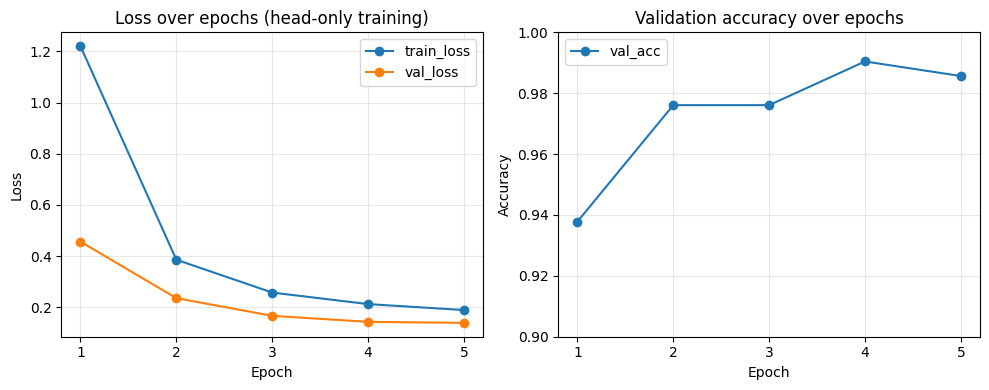

In [21]:
import matplotlib.pyplot as plt

epochs = range(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(10, 4))

# Loss curves
plt.subplot(1, 2, 1)
plt.plot(epochs, history["train_loss"], marker="o", label="train_loss")
plt.plot(epochs, history["val_loss"], marker="o", label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over epochs (head-only training)")
plt.xticks(epochs)
plt.legend()
plt.grid(True, alpha=0.3)

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(epochs, history["val_acc"], marker="o", label="val_acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation accuracy over epochs")
plt.xticks(epochs)
plt.ylim(0.9, 1)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

**Interpreting the curves**

- A **decreasing training loss** indicates our classifier head is learning a better mapping from fixed features to labels.  
- If **validation loss** also decreases and **validation accuracy** increases, the head is generalizing beyond the training set.  
- If validation metrics **plateau early**, that suggests the frozen features already provide a strong separation and additional epochs add little benefit.  
- If training loss drops while validation loss rises, that indicates **overfitting**. In that case, consider:
   - **Early stopping**: stop training when validation loss does not improve for $p$ consecutive epochs.  
   - **Regularization**: weight decay, dropout in the head.  
   - **Data augmentation**: mild geometric or color transforms.  
   - **Fine-tuning** (NB03): unfreeze a small number of deeper layers with a **lower learning rate** to adapt features to the target domain.

Because we are training only a small number of parameters on top of a powerful pretrained backbone, we typically see **fast, stable convergence** in just a few epochs on CPU.


---

**✅ Code Task 11.2.4.1: Continue head-only training for 5 more epochs (append history)**

**Student instruction:** Using the existing `model`, `train_one_epoch`, `evaluate`, `optimizer`, `criterion`, `scheduler`, `train_loader`, and `val_loader`, we append 5 additional epochs to `history["train_loss"]`, `history["val_loss"]`, and `history["val_acc"]`. Keep the scheduler stepping each epoch if present.

In [ ]:
import time

CT_extra_epochs = 5
assert isinstance(history, dict) and all(k in history for k in ["train_loss","val_loss","val_acc"]), \
    "history dict missing keys."

CT_start_len = len(history["train_loss"])

for ep in range(1, CT_extra_epochs + 1):
    tr_loss = train_one_epoch(..., ..., optimizer, criterion, device)
    va_loss, va_acc = evaluate(..., ..., criterion, device)
    if scheduler is not None:
        scheduler.step()
    history["train_loss"].append(...)
    history["val_loss"].append(...)
    history["val_acc"].append(...)
    print(f"Extra Epoch {ep:02d} | "
        f"train_loss={tr_loss:.4f} | "
        f"val_loss={va_loss:.4f} | "
        f"val_acc={va_acc:.3f}")

CT_end_len = len(history["train_loss"])
print(f"History grew from {CT_start_len} → {CT_end_len}")

**Instructor Solution**

In [22]:
import time

CT_extra_epochs = 5
assert isinstance(history, dict) and all(k in history for k in ["train_loss","val_loss","val_acc"])

CT_start_len = len(history["train_loss"])

for ep in range(1, CT_extra_epochs + 1):
    tr_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    va_loss, va_acc = evaluate(model, val_loader, criterion, device)
    if scheduler is not None:
        scheduler.step()
    history["train_loss"].append(tr_loss)
    history["val_loss"].append(va_loss)
    history["val_acc"].append(va_acc)
    print(f"Extra Epoch {ep:02d} | "
        f"train_loss={tr_loss:.4f} | "
        f"val_loss={va_loss:.4f} | "
        f"val_acc={va_acc:.3f}")

CT_end_len = len(history["train_loss"])
print(f"History grew from {CT_start_len} → {CT_end_len}")


Extra Epoch 00 | train_loss=0.1636 | val_loss=0.1328 | val_acc=0.986
Extra Epoch 01 | train_loss=0.1658 | val_loss=0.1185 | val_acc=0.986
Extra Epoch 02 | train_loss=0.1585 | val_loss=0.1169 | val_acc=0.971
Extra Epoch 03 | train_loss=0.1483 | val_loss=0.1226 | val_acc=0.986
Extra Epoch 04 | train_loss=0.1537 | val_loss=0.1076 | val_acc=0.990
History grew from 5 → 10


In [ ]:
assert CT_end_len - CT_start_len == 5, "❌ Must append exactly 5 new epochs."
for k in ["train_loss","val_loss","val_acc"]:
    arr = history[k][-5:]
    assert len(arr) == 5 and all(isinstance(x, float) for x in arr), f"❌ {k} last 5 entries invalid."
print("✅ CT_Task 2 passed.")

---

**✅ Code Task 11.2.4.2: Plot extended curves (save to PNG)**

**Student instruction:** Plot the full history after the extra 5 epochs and save as ct_history_plot.png. Include: (i) train vs val loss; (ii) val accuracy.

In [ ]:
import matplotlib.pyplot as plt

CT_epochs = range(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(..., ..., marker='o', label='train_loss')
plt.plot(..., ..., marker='o', label='val_loss')
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss (extended)"); plt.legend(); plt.grid(True, alpha=0.3)

plt.subplot(1,2,2)
plt.plot(..., ..., marker='o', label='val_acc')
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Val Acc (extended)"); plt.legend(); plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("ct_history_plot.png", dpi=150, bbox_inches='tight')
print("Saved ct_history_plot.png")

**Instructor Solution**

In [ ]:
import matplotlib.pyplot as plt

CT_epochs = range(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(CT_epochs, history["train_loss"], marker='o', label='train_loss')
plt.plot(CT_epochs, history["val_loss"], marker='o', label='val_loss')
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss (extended)"); plt.legend(); plt.grid(True, alpha=0.3)

plt.subplot(1,2,2)
plt.plot(CT_epochs, history["val_acc"], marker='o', label='val_acc')
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Val Acc (extended)"); plt.legend(); plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("ct_history_plot.png", dpi=150, bbox_inches='tight')
print("Saved ct_history_plot.png")


In [ ]:
import os
assert os.path.exists("ct_history_plot.png"), "❌ Plot file not found: ct_history_plot.png"
assert len(history["train_loss"]) == len(history["val_loss"]) == len(history["val_acc"]), "❌ History lengths mismatch."
print("✅ CT_Task 3 passed.")

---

### **5. Evaluating on the Test Set**

After training the classifier head, we now evaluate its performance on the **held-out test set**.  
Our goal is to understand not only the **overall accuracy**, but also how performance varies **per class**, and which classes tend to be **confused** with one another.

We will compute:
- **Overall accuracy** — proportion of correctly classified test images.
- **Per-class precision, recall, and F1** — these give a richer view than accuracy alone:
  - Precision (for a class $c$): $ \text{Prec}_c = \frac{\text{TP}_c}{\text{TP}_c + \text{FP}_c} $
  - Recall (for a class $c$): $ \text{Rec}_c = \frac{\text{TP}_c}{\text{TP}_c + \text{FN}_c} $
  - F1 (for a class $c$): $ \text{F1}_c = \frac{2 \cdot \text{Prec}_c \cdot \text{Rec}_c}{\text{Prec}_c + \text{Rec}_c} $
- A **confusion matrix heatmap** — this visualizes how predictions distribute across classes for each true label.

Interpreting these results will help us reason about:
- Which classes are **easier** (high recall and precision),
- Which classes are **harder** (lower scores),
- Where **systematic confusions** occur (e.g., visually similar categories).

We keep evaluation strictly with `torch.no_grad()` to ensure we do not alter model weights or track gradients during testing.


**Run inference and collect predictions**

In [24]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

model.eval()

y_true, y_pred, y_prob = [], [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        logits = model(xb)
        probs = torch.softmax(logits, dim=1)

        preds = torch.argmax(probs, dim=1).cpu().numpy()
        y_pred.extend(preds.tolist())
        y_true.extend(yb.numpy().tolist())
        y_prob.extend(probs.cpu().numpy().tolist())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)

test_acc = accuracy_score(y_true, y_pred)
print(f"[test] Overall accuracy: {test_acc:.4f}")

[test] Overall accuracy: 0.9853


**Per-class precision/recall/F1 and macro/micro averages**

In [25]:
from sklearn.metrics import classification_report

# Build a label list in the correct index order for the report
target_names = [class_names[i] for i in range(len(class_names))]

report = classification_report(
    y_true, y_pred, target_names=target_names, digits=3, zero_division=0
)
print(report)


              precision    recall  f1-score   support

       Faces      1.000     1.000     1.000        37
  Motorbikes      0.974     1.000     0.987        37
   airplanes      1.000     1.000     1.000        37
   butterfly      1.000     0.923     0.960        13
      camera      1.000     1.000     1.000         7
       chair      0.900     0.900     0.900        10
      laptop      1.000     1.000     1.000        12
       lotus      1.000     1.000     1.000        10
       panda      1.000     0.800     0.889         5
       watch      0.973     1.000     0.986        36

    accuracy                          0.985       204
   macro avg      0.985     0.962     0.972       204
weighted avg      0.986     0.985     0.985       204



**Confusion matrix (raw and normalized) + heatmaps**

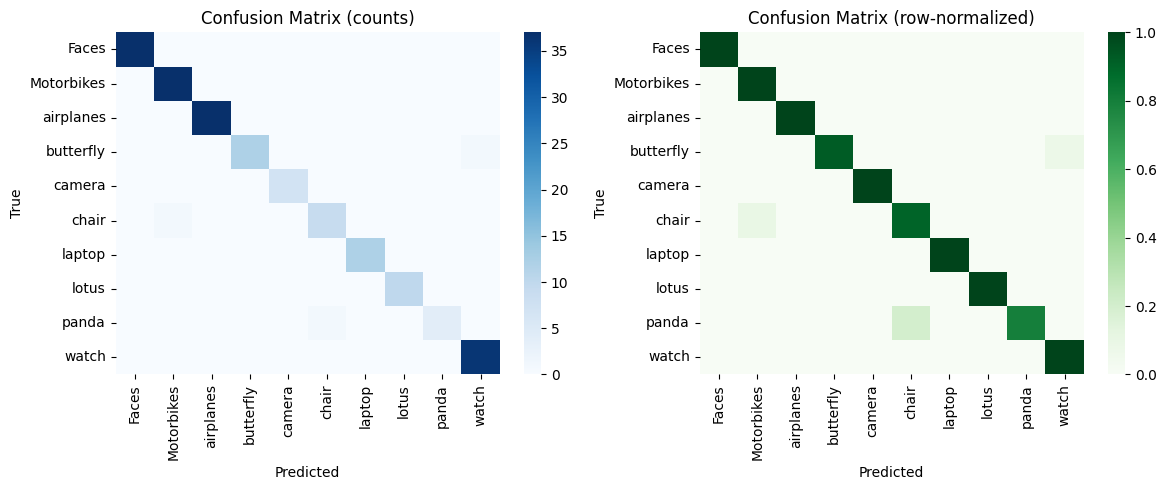

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred, labels=list(range(len(class_names))))
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True).clip(min=1)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm, annot=False, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names, ax=axes[0])
axes[0].set_title("Confusion Matrix (counts)")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

sns.heatmap(cm_norm, annot=False, cmap="Greens", vmin=0.0, vmax=1.0,
            xticklabels=class_names, yticklabels=class_names, ax=axes[1])
axes[1].set_title("Confusion Matrix (row-normalized)")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")

plt.tight_layout()
plt.show()


**Inspect the most confused class pairs (optional)**

In [41]:
import numpy as np

# Exclude diagonal to find top confusions (by normalized rate)
cm_offdiag = cm_norm.copy()
np.fill_diagonal(cm_offdiag, 0.0)

# Get top-K confused pairs
K = 5
pairs = []
for i in range(len(class_names)):
    for j in range(len(class_names)):
        if i != j:
            pairs.append((cm_offdiag[i, j], i, j))
pairs.sort(reverse=True)
top_pairs = pairs[:K]

print("[insight] Top confused class pairs (normalized rates):")
for val, i, j in top_pairs:
    print(f"  True='{class_names[i]}' → Pred='{class_names[j]}' : {val:.3f}")


[insight] Top confused class pairs (normalized rates):
  True='panda' → Pred='chair' : 0.200
  True='chair' → Pred='Motorbikes' : 0.100
  True='butterfly' → Pred='watch' : 0.077
  True='watch' → Pred='panda' : 0.000
  True='watch' → Pred='lotus' : 0.000


**Visualize a few misclassified images (optional)**

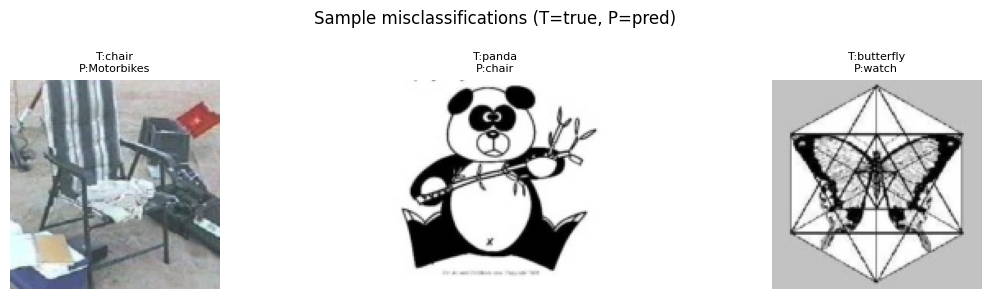

In [38]:
import matplotlib.pyplot as plt
from PIL import Image

# Rebuild a flat list of filepaths in the same order as test_loader iteration
# so we can display misclassified examples
test_paths = []
for paths, _ in [( [p for p,_ in test_loader.dataset.samples], test_loader.dataset.targets )]:
    test_paths = paths

# If the above shortcut is unclear on some torch/torchvision versions,
# we can rebuild from the dataset directly:
if not test_paths:
    test_paths = [p for p, _ in test_loader.dataset.samples]

mis_idx = np.where(y_true != y_pred)[0]
k = min(8, len(mis_idx))
if k > 0:
    sel = np.random.choice(mis_idx, size=k, replace=False)
    plt.figure(figsize=(12, 3))
    for t, idx in enumerate(sel):
        # Recover image path; idx corresponds to dataset order if no shuffling between batches
        # Since DataLoader shuffles only train, test_loader preserves dataset order.
        img_path = test_paths[idx]
        img = Image.open(img_path).convert("RGB")

        plt.subplot(1, k, t+1)
        plt.imshow(img)
        true_lbl = class_names[y_true[idx]]
        pred_lbl = class_names[y_pred[idx]]
        plt.title(f"T:{true_lbl}\nP:{pred_lbl}", fontsize=8)
        plt.axis("off")
    plt.suptitle("Sample misclassifications (T=true, P=pred)", fontsize=12)
    plt.tight_layout()
    plt.show()
else:
    print("[info] No misclassifications in sampled set (or very small test set).")


**How do we read these results?**

 - **Overall accuracy** provides a quick snapshot of performance, but it may hide class imbalances.  
 - **Per-class precision/recall/F1** reveal which categories are easier or harder.  
   - Low **recall** for a class means many of its images are missed (false negatives).  
   - Low **precision** for a class means many predictions for that class are incorrect (false positives).
 - The **confusion matrix** highlights systematic mistakes. If two classes are often confused with each other, it could be due to:
   - Visual similarity (e.g., similar textures or shapes),  
   - Background clutter or pose variation,  
   - Limited examples for the rarer class in our subset.

Because our backbone was **pretrained on ImageNet**, many categories that share common structures should already be well separated in feature space.  

If we still see persistent confusion between specific pairs, this sets up a natural motivation for **NB03 (fine-tuning)**:
 - We can unfreeze a deeper block (e.g., `layer4`) and use a **smaller learning rate** to adapt features for those difficult distinctions.  
 - We can also consider **data augmentation** or **class rebalancing** if the dataset is skewed.


---

**✅ Code Task 11.2.5.1: Show upto 4 misclassified Butterfly images (T: / P:)**

**Student instruction:** From the test split, display up to 4 misclassified images where the true label is “butterfly”. Title each subplot as `T: <true>` `P: <pred>`.

If your subset lacks “butterfly”, display any other single class’s misclassified samples and set CT_used_class accordingly.

Shown misclassified samples for class: butterfly (count=1)


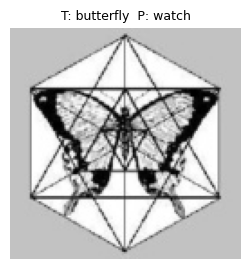

In [ ]:
import torch, numpy as np, matplotlib.pyplot as plt
from PIL import Image

model.eval()
CT_target = ...
if CT_target not in ...:
    CT_target = class_names[0]

# 1) Collect predictions over test set
CT_y_true, CT_y_pred = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        logits = model(xb.to(...))
        preds = logits.argmax(1).cpu().numpy()
        CT_y_pred.extend(preds.tolist())
        CT_y_true.extend(yb.numpy().tolist())
CT_y_true = np.array(...)
CT_y_pred = np.array(...)

# 2) Map dataset order to file paths
CT_test_paths = [p for p,_ in test_loader.dataset.samples]

# 3) Filter indices: true == CT_target & misclassified
CT_target_idx = class_names.index(...)
CT_mis_idx = np.where((... == CT_target_idx) & (... != CT_target_idx))[0]
CT_sel = CT_mis_idx[:4]

CT_mis_paths, CT_titles = [], []
plt.figure(figsize=(12,3))
for i, idx in enumerate(CT_sel):
    img = Image.open(CT_test_paths[idx]).convert("RGB")
    plt.subplot(1, len(CT_sel), i+1)
    plt.imshow(img); plt.axis("off")
    t_lbl = class_names[CT_y_true[idx]]; p_lbl = class_names[CT_y_pred[idx]]
    title = f"T: {t_lbl}  P: {p_lbl}"
    CT_titles.append(title); CT_mis_paths.append(CT_test_paths[idx])
    plt.title(title, fontsize=9)

CT_used_class = CT_target
print(f"Shown misclassified samples for class: {CT_used_class} (count={len(CT_sel)})")


**Instructor Solution**

In [ ]:
import torch, numpy as np, matplotlib.pyplot as plt
from PIL import Image

model.eval()
CT_target = "butterfly"  # fallback to another class if absent
if CT_target not in class_names:
    CT_target = class_names[0]

# 1) Collect predictions over test set
CT_y_true, CT_y_pred = [], []
with torch.no_grad():
    for xb, yb in test_loader:
        logits = model(xb.to(device))
        preds = logits.argmax(1).cpu().numpy()
        CT_y_pred.extend(preds.tolist())
        CT_y_true.extend(yb.numpy().tolist())
CT_y_true = np.array(CT_y_true); CT_y_pred = np.array(CT_y_pred)

# 2) Map dataset order to file paths
CT_test_paths = [p for p,_ in test_loader.dataset.samples]

# 3) Filter indices: true == CT_target & misclassified
CT_target_idx = class_names.index(CT_target)
CT_mis_idx = np.where((CT_y_true == CT_target_idx) & (CT_y_pred != CT_target_idx))[0]
CT_sel = CT_mis_idx[:4]

CT_mis_paths, CT_titles = [], []
plt.figure(figsize=(12,3))
for i, idx in enumerate(CT_sel):
    img = Image.open(CT_test_paths[idx]).convert("RGB")
    plt.subplot(1, len(CT_sel), i+1)
    plt.imshow(img); plt.axis("off")
    t_lbl = class_names[CT_y_true[idx]]; p_lbl = class_names[CT_y_pred[idx]]
    title = f"T: {t_lbl}  P: {p_lbl}"
    CT_titles.append(title); CT_mis_paths.append(CT_test_paths[idx])
    plt.title(title, fontsize=9)

CT_used_class = CT_target
print(f"Shown misclassified samples for class: {CT_used_class} (count={len(CT_sel)})")


In [ ]:
assert 'CT_used_class' in globals(), "❌ CT_used_class missing."
assert isinstance(CT_mis_paths, list) and isinstance(CT_titles, list), "❌ Outputs must be lists."
if len(CT_mis_paths) > 0:
    assert all(isinstance(p, str) for p in CT_mis_paths), "❌ Paths must be strings."
    assert all(("T:" in t and "P:" in t) for t in CT_titles), "❌ Titles must include 'T:' and 'P:'."
print("✅ CT_Task 4 passed (len =", len(CT_mis_paths), ")")


---

**✅ Code Task 11.2.5.2: Per-class accuracy + Top-3 worst classes**

**Student instruction:** Compute per-class accuracy from the confusion matrix (test set) and store in `CT_per_class_acc` (NumPy array aligned with `class_names`). Also compute `CT_worst3` as a list of 3 tuples `(class_name, accuracy_float)` for the worst classes.

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Reuse predictions from earlier cells or recompute quickly:
CT_true, CT_pred = [], []
model.eval()
with torch.no_grad():
    for xb, yb in test_loader:
        logits = model(xb.to(...))
        preds = logits.argmax(1).cpu().numpy()
        CT_pred.extend(....tolist())
        CT_true.extend(yb.numpy().tolist())
CT_true = np.array(...)
CT_pred = np.array(...)

CT_cm = confusion_matrix(..., ..., labels=list(range(len(...))))
CT_row_sums = CT_cm.sum(axis=1).clip(min=1)
CT_per_class_acc = ...  # np.diag(CT_cm) / CT_row_sums

# Build worst-3 list of (name, acc)
CT_order = np.argsort(...)[:3]
CT_worst3 = [(class_names[i], float(CT_per_class_acc[i])) for i in CT_order]
print("Worst-3 classes:", CT_worst3)


**Instructor Solution**

In [40]:
from sklearn.metrics import confusion_matrix
import numpy as np

CT_true, CT_pred = [], []
model.eval()
with torch.no_grad():
    for xb, yb in test_loader:
        logits = model(xb.to(device))
        preds = logits.argmax(1).cpu().numpy()
        CT_pred.extend(preds.tolist())
        CT_true.extend(yb.numpy().tolist())
CT_true = np.array(CT_true); CT_pred = np.array(CT_pred)

CT_cm = confusion_matrix(CT_true, CT_pred, labels=list(range(len(class_names))))
CT_row_sums = CT_cm.sum(axis=1).clip(min=1)
CT_per_class_acc = np.diag(CT_cm) / CT_row_sums

CT_order = np.argsort(CT_per_class_acc)[:3]
CT_worst3 = [(class_names[i], float(CT_per_class_acc[i])) for i in CT_order]
print("Worst-3 classes:", CT_worst3)


Worst-3 classes: [('panda', 0.8), ('chair', 0.9), ('butterfly', 0.9230769230769231)]


In [ ]:
import numpy as np
assert isinstance(CT_per_class_acc, np.ndarray), "❌ CT_per_class_acc must be a NumPy array."
assert CT_per_class_acc.shape[0] == len(class_names), "❌ Length mismatch vs class_names."
assert isinstance(CT_worst3, list) and len(CT_worst3) == 3, "❌ CT_worst3 must have 3 items."
assert all(isinstance(t[0], str) and isinstance(t[1], float) for t in CT_worst3), "❌ CT_worst3 format incorrect."
print("✅ CT_Task 5 passed.")


---

### **6. Visualizing Predictions and Model Confidence**

To build intuition about what our classifier head has learned, we will **visualize predictions on a few test images**.  
For each image, we will display the **true label**, the **predicted label**, and the model’s **confidence** (the highest softmax probability).

Why is this useful?

- Seeing predictions next to images helps us connect **numbers to visual patterns**.  
- The **confidence score** offers a quick sense of how certain the model is about its decision.  
- When the model is wrong with **high confidence**, that often hints at **systematic confusion** between visually similar classes or strong **background biases**.  
- When the model is right with high confidence, it suggests that **pretrained features** already separate categories effectively in feature space, even though we trained only the final layer.

As we scan through examples, we should ask:

- Are errors due to **visual similarity** between categories?  
- Do **viewpoint changes** or **occlusions** cause confusion?  
- Is the **background** misleading the model?  
- Do confident correct predictions align with clear, distinctive object cues?

This qualitative inspection complements our quantitative metrics and helps us decide what to try next in NB03, such as **fine-tuning** deeper layers or applying **data augmentation**.


**Grid of predictions with confidence**

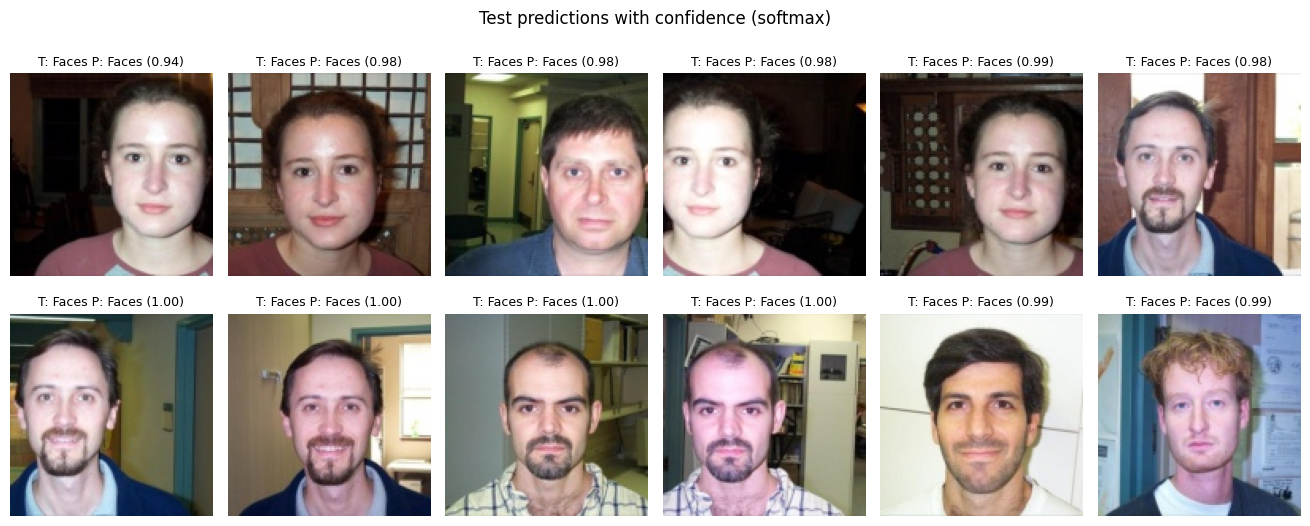

In [15]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

# Helper for unnormalizing tensors for display
def unnormalize(img_tensor, mean, std):
    img = img_tensor.clone()
    for c, (m, s) in enumerate(zip(mean, std)):
        img[c] = img[c] * s + m
    return img.clamp(0, 1)

# Get one batch from the test loader
model.eval()
xb, yb = next(iter(test_loader))
xb_dev = xb.to(device)

with torch.no_grad():
    logits = model(xb_dev)
    probs = F.softmax(logits, dim=1).cpu()

pred_idx = probs.argmax(dim=1).numpy()
true_idx = yb.numpy()
conf = probs.max(dim=1).values.numpy()

# Pick up to 12 examples for a compact grid
k = min(12, xb.size(0))
cols = 6
rows = int(np.ceil(k / cols))

plt.figure(figsize=(cols * 2.2, rows * 2.8))

for i in range(k):
    img_disp = unnormalize(xb[i], IMAGENET_MEAN, IMAGENET_STD).permute(1, 2, 0).numpy()
    t_lbl = class_names[true_idx[i]]
    p_lbl = class_names[pred_idx[i]]
    cval = conf[i]

    plt.subplot(rows, cols, i + 1)
    plt.imshow(img_disp)
    title = f"T: {t_lbl} P: {p_lbl} ({cval:.2f})"
    plt.title(title, fontsize=9)
    plt.axis("off")

plt.suptitle("Test predictions with confidence (softmax)", fontsize=12)
plt.tight_layout()
plt.show()


**What patterns do we observe in the grid above?**

 - **Correct, high-confidence predictions** suggest that the pretrained backbone already places those images in well-separated regions of feature space.  
 - **Low-confidence predictions** often occur when images are ambiguous, small, or have cluttered backgrounds.  
 - **Wrong but high-confidence predictions** usually indicate **systematic confusion** between visually similar classes or strong background cues that mislead the model.

These observations reinforce our key idea: **pretrained features** already provide a powerful representation.  

Training only the head leverages this representation effectively, but when confusions persist, we can try:
 - **Mild data augmentation** to improve robustness to viewpoint and background,  
 - **Class rebalancing** if the dataset is skewed,  
 - **Fine-tuning** deeper layers with a smaller learning rate in NB03 to adapt the representation to our specific categories.

---

### **7. Reflection: What Feature Extraction Achieves**

Now that we’ve completed the **feature extraction stage**, it’s important to step back and reflect on *what exactly we achieved* — both conceptually and practically.

**What knowledge did we reuse?**

The convolutional backbone of our pretrained ResNet18 was trained on **ImageNet**, a massive dataset of over one million natural images across 1,000 categories.  
Through this pretraining, the model learned **universal visual features**:
- Early layers capture **edges**, **colors**, and **textures**.  
- Mid-level layers detect **shapes**, **parts**, and **motifs**.  
- Deeper layers abstract **object-level semantics**.

When we froze these layers and trained only the final classifier head, we effectively **reused that entire visual hierarchy** as a powerful, pre-built feature extractor.  
This allowed us to train quickly and achieve strong results even with a small dataset.

**Why was training so fast?**

Because only the **final linear layer** had learnable parameters, the number of trainable weights was tiny compared to the full network.  
No gradient computations or updates occurred for the frozen layers, so:
- The forward and backward passes were lighter.  
- Memory and computation costs were minimal.  
- We could train to convergence within minutes, even on CPU.

This is the main benefit of **feature extraction** — we reuse knowledge instead of learning everything from scratch.

**Freezing vs. Fine-Tuning: The Trade-Off**

Let’s reason conceptually about the two transfer learning stages:

| Aspect | **Feature Extraction (this notebook)** | **Fine-Tuning (next notebook)** |
|:-------|:---------------------------------------|:--------------------------------|
| Trainable Parameters | Only final layer | Some or all layers |
| Speed | Very fast | Slower |
| Overfitting Risk | Low | Higher (needs care) |
| Adaptability | Limited (fixed features) | High (features adapt) |
| When to Use | Small dataset, similar domain | Larger dataset, domain gap |

By freezing, we **preserve pretrained knowledge** and reduce the risk of overfitting.  
By fine-tuning, we **adapt representations** for new visual characteristics but at a higher computational and overfitting risk.

**Representation Transferability**

Not all layers in a CNN are equally transferable.  
Empirical studies show:

- **Early layers** are *general-purpose* — useful across many tasks.  
- **Deeper layers** are *task-specific* — tuned to the original dataset’s categories.  

This means:
- For **similar domains** (e.g., natural images → natural images), feature extraction often suffices.  
- For **different domains** (e.g., medical scans → natural images), we must fine-tune deeper layers to adapt features.

**Reflection Prompts**

Let’s think about what we observed and learned:

1. Which parts of the pretrained model contributed most to our fast convergence?  
2. How did the small classifier head learn to leverage these fixed features?  
3. Why might some classes still show confusion despite strong pretrained features?  
4. What could fine-tuning achieve that feature extraction cannot?

By reflecting on these points, we recognize the essence of **transfer learning**:  
> *We stand on the shoulders of pretrained giants, reusing their learned representations and adapting them efficiently to our own tasks.*


---

### **8. Saving Trained Head and Performance Logs**

Before moving on, we’ll save everything necessary for our next notebook (NB03), where we’ll explore **fine-tuning**.  
Saving intermediate results allows us to **resume seamlessly** and **reproduce experiments** later.

We will save:
- The **entire model state dictionary**, which includes both:
  - The **frozen backbone** (still pretrained on ImageNet),
  - The **trained classifier head** (which we just optimized).
- The **training logs** (losses and accuracies) as a `.json` file for later visualization or comparison.

This ensures we can directly reload our feature-extracted model in NB03 and start fine-tuning from this checkpoint without retraining from scratch.


**Save model and logs**

In [24]:
import json
from pathlib import Path

save_dir = Path("./checkpoints")
save_dir.mkdir(parents=True, exist_ok=True)

model_path = save_dir / "resnet18_feature_extraction.pth"
torch.save(model.state_dict(), model_path)

logs = {
    "train_loss": history["train_loss"],
    "val_loss": history["val_loss"],
    "val_acc": history["val_acc"]
}

with open(save_dir / "training_logs_feature_extraction.json", "w") as f:
    json.dump(logs, f, indent=4)

print(f"[done] Saved model to: {model_path}")
print(f"[done] Saved training logs to: {save_dir/'training_logs_feature_extraction.json'}")


[done] Saved model to: checkpoints\resnet18_feature_extraction.pth
[done] Saved training logs to: checkpoints\training_logs_feature_extraction.json


---

### **9. Summary and What Comes Next**

Let’s reflect on what we achieved in this notebook:

- We **loaded the pretrained ResNet18** backbone and **replaced its head** with a new classifier for our 10 Caltech categories.  
- We **froze all pretrained layers**, training only the small classifier head — this stage is called **feature extraction**.  
- The model **converged quickly** and achieved strong accuracy even with limited data, showing how **transfer learning** drastically reduces data and computation needs.  
- We explored model evaluation through **accuracy, F1 scores, confusion matrices, and qualitative predictions**, gaining both numerical and visual insights into model behavior.


**What comes next (NB03): Fine-Tuning**

In the next notebook, we’ll **unfreeze selected layers** of the pretrained backbone (for example, `layer4`) and **fine-tune** them along with the head.

We’ll discuss:
- How to set **different learning rates** for different layers,
- The risk of **catastrophic forgetting** (overwriting pretrained knowledge),
- How fine-tuning can improve performance when the target dataset diverges from the pretraining domain.


> **Key takeaway:**  
> Feature extraction allows us to stand on top of pretrained knowledge.  
> Fine-tuning lets us carefully reshape that knowledge for our new problem.
